In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pypdf import PdfWriter

In [2]:
with open('softcheck5.pkl', 'rb') as file:
    events = pickle.load(file)

In [6]:
print(len(events))
print(type(events[0]))
print(events)

449
<class 'bytes'>
[b'\x00\x01\x07\x00\x00\x00z\xda?\x001E\x00\x00\x00\x00\xd7\x00\x00\x00\xa4\x13\x00\x00iARYE\xe8\xdeQ\x00\x00\x00\x00\x00\x00\x00\x80\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8b\x8b\x8b\x8b\x8b\x8b\x00\x00dddddd\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [9]:
theEvent=events#[182]

In [10]:
print(len(theEvent))

449


229504


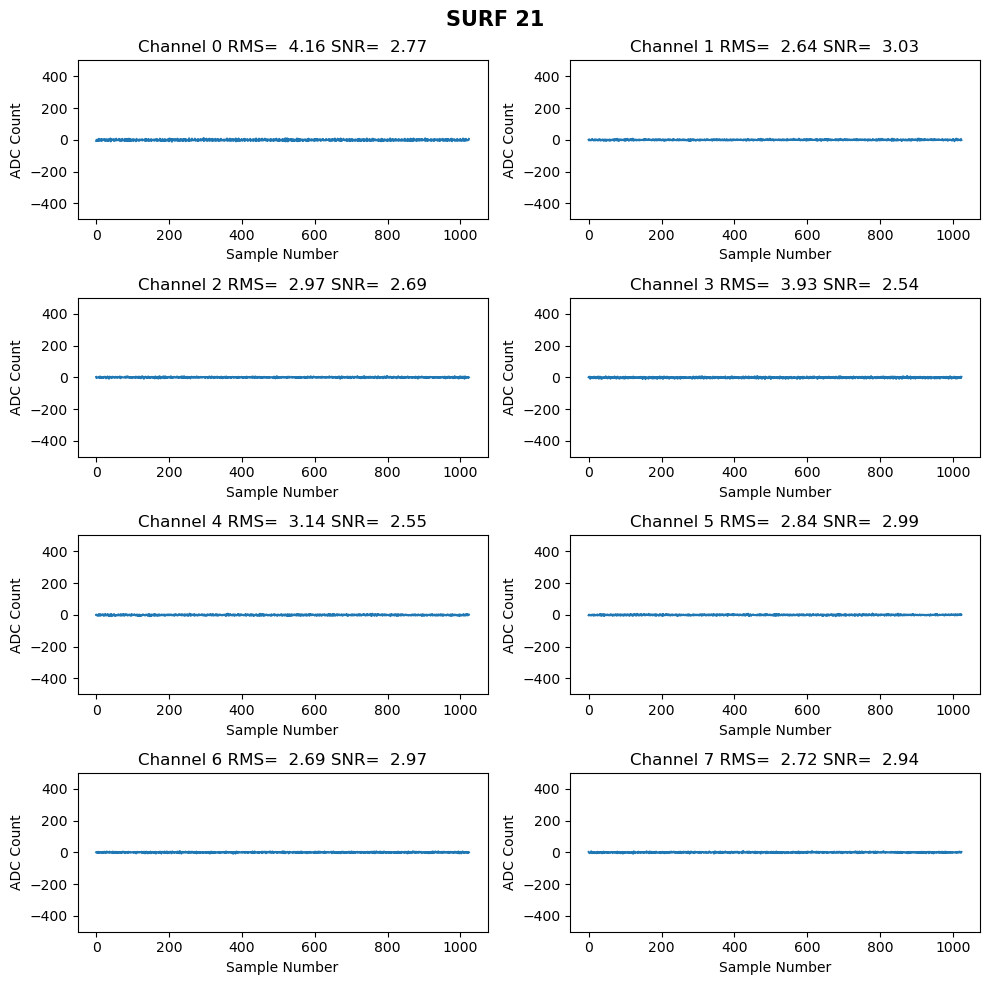

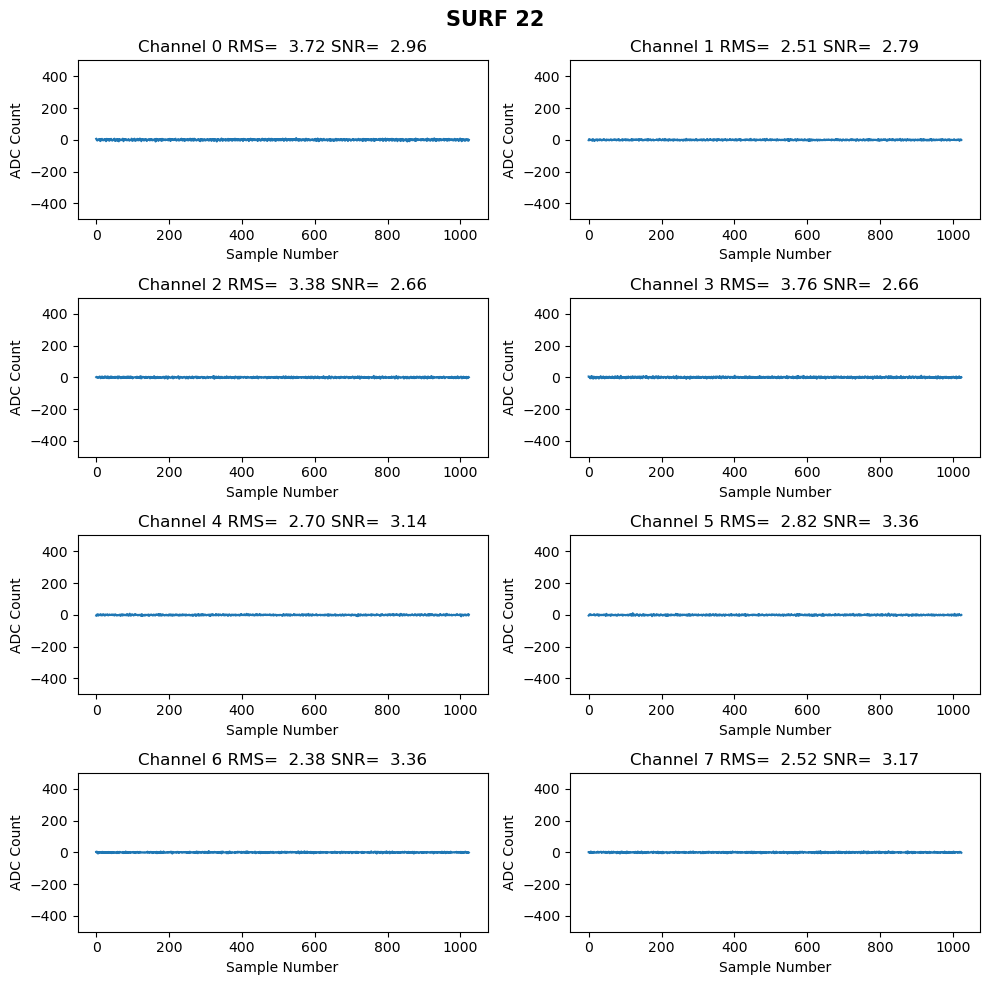

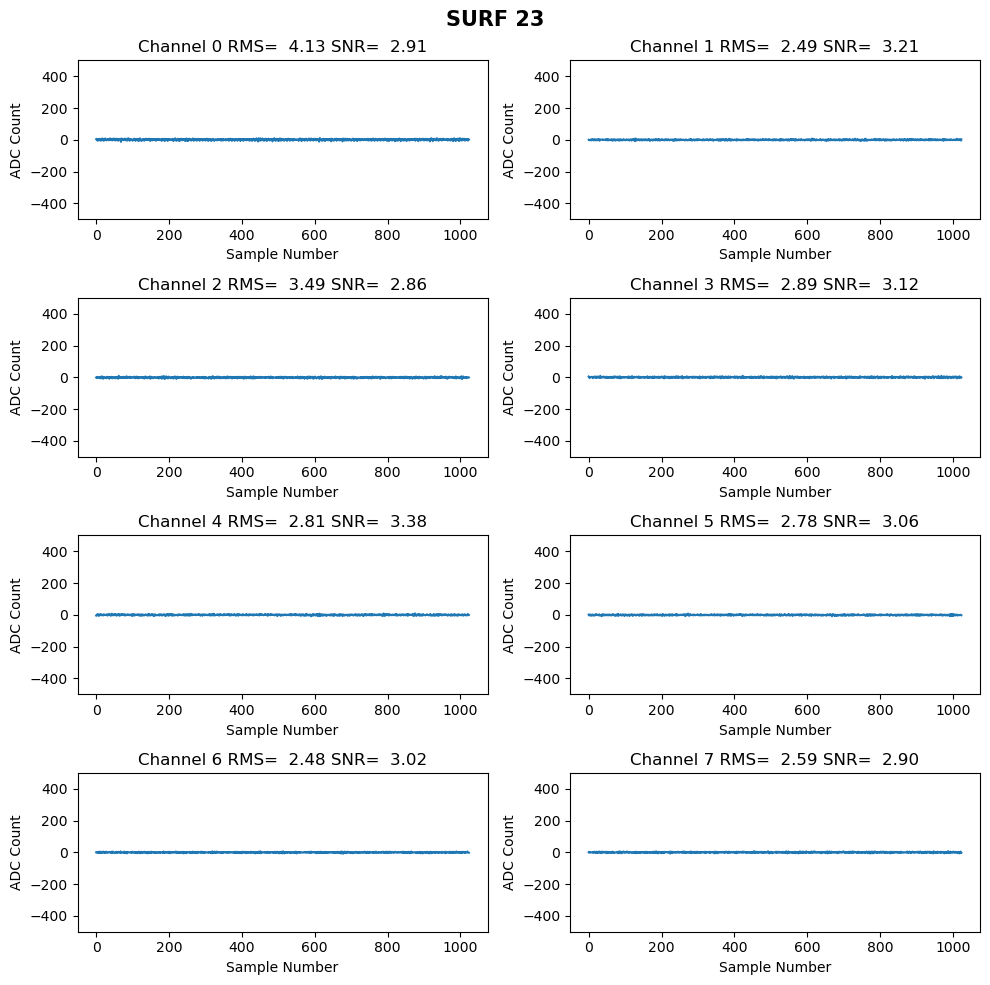

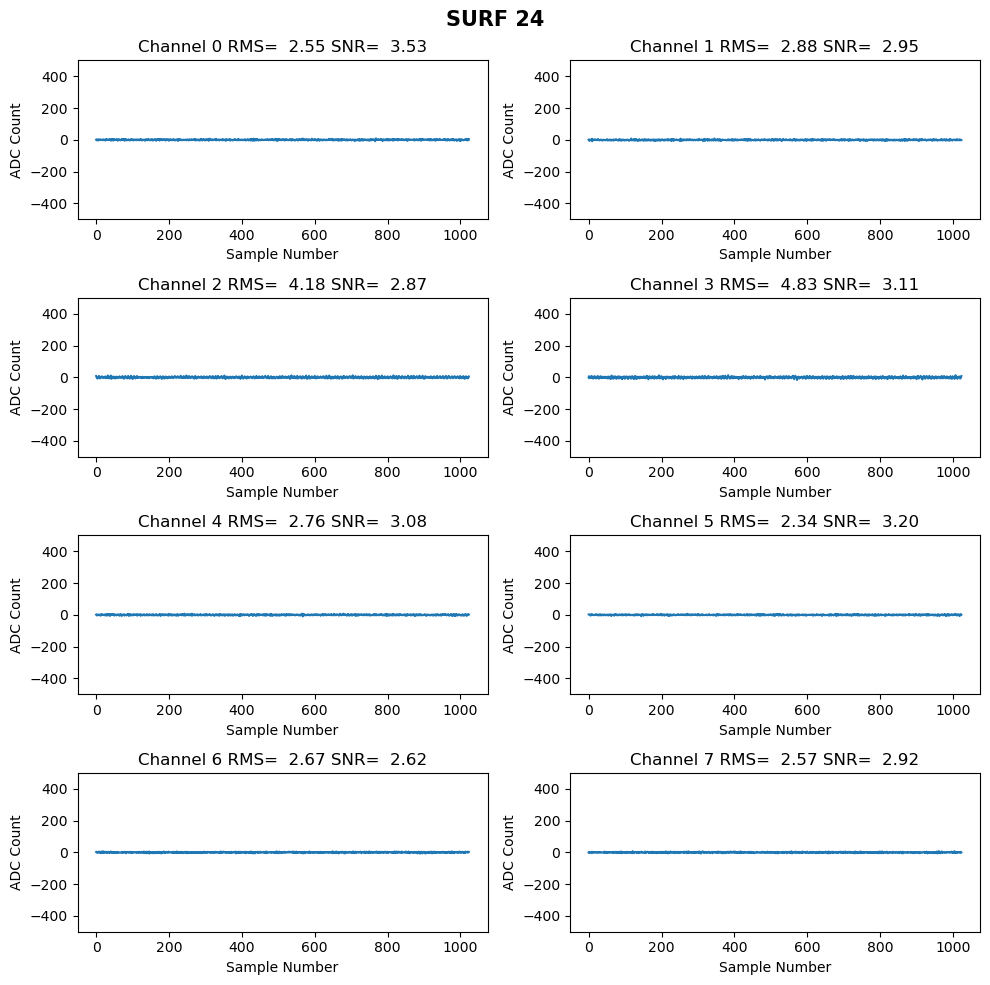

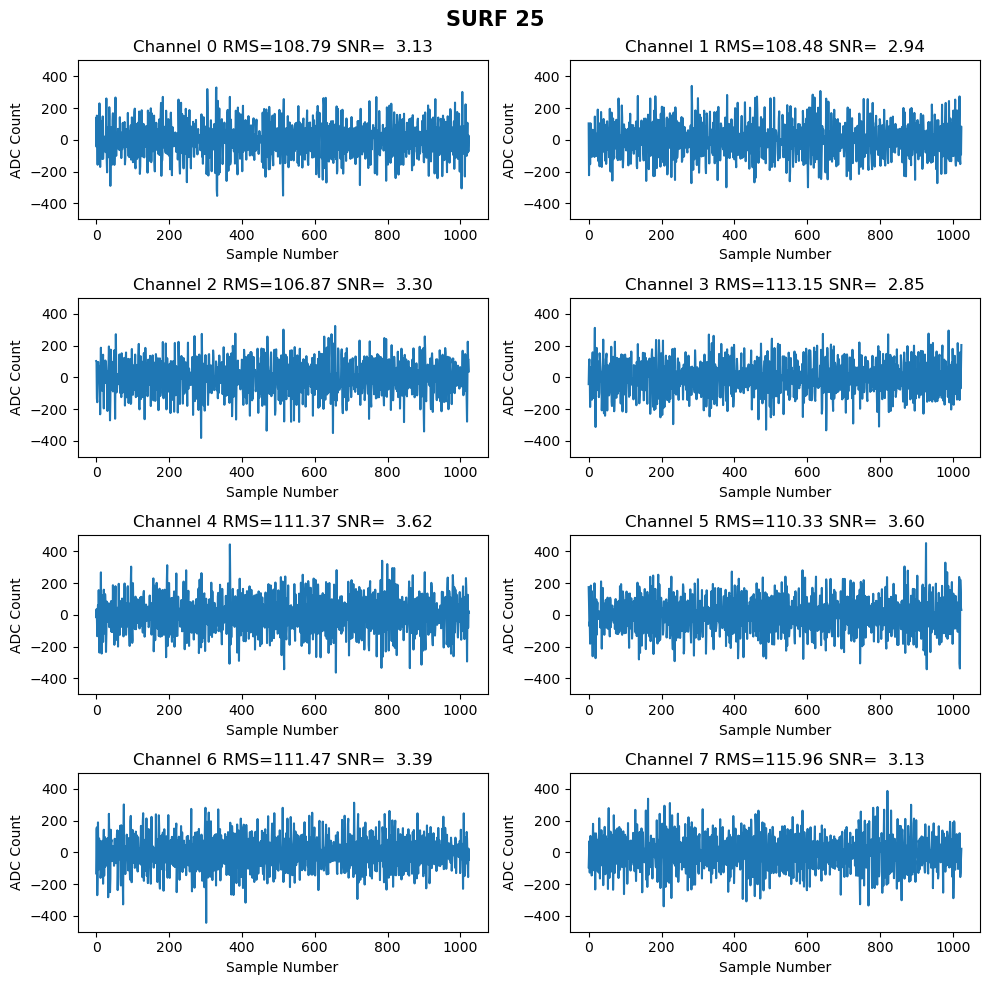

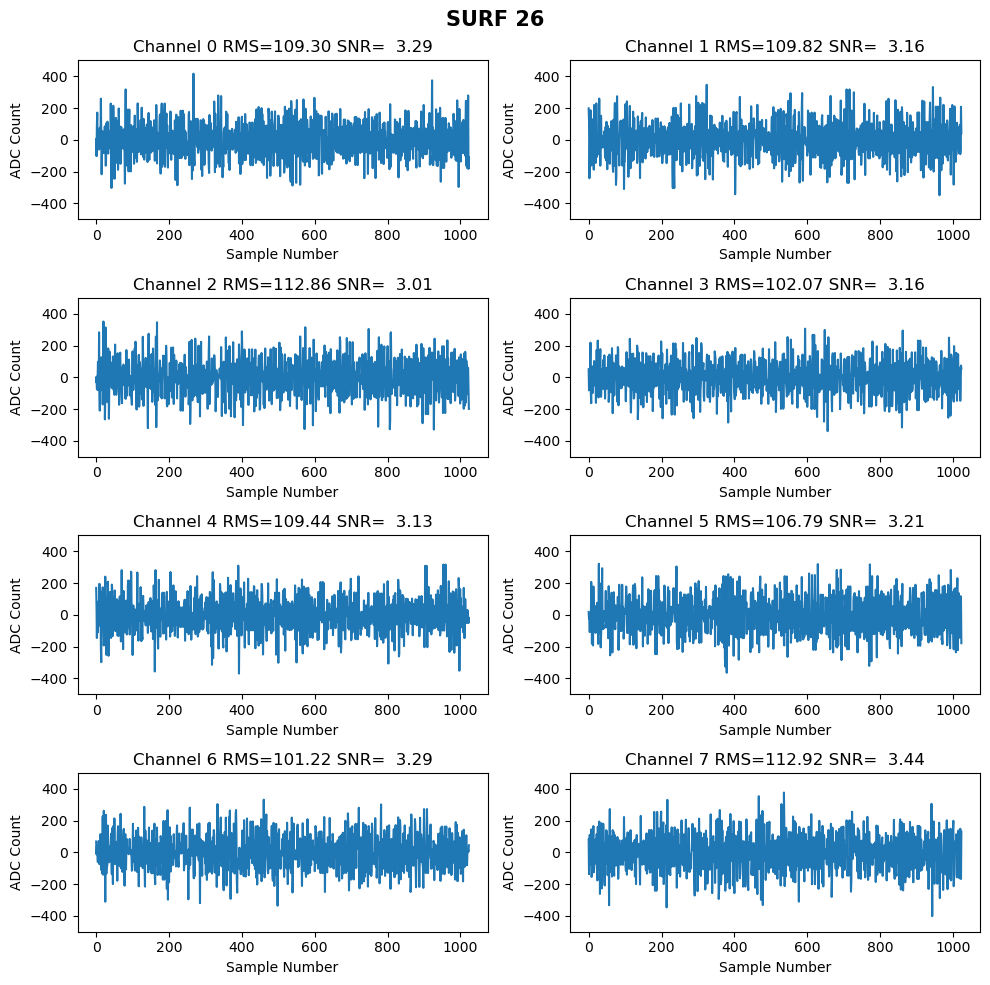

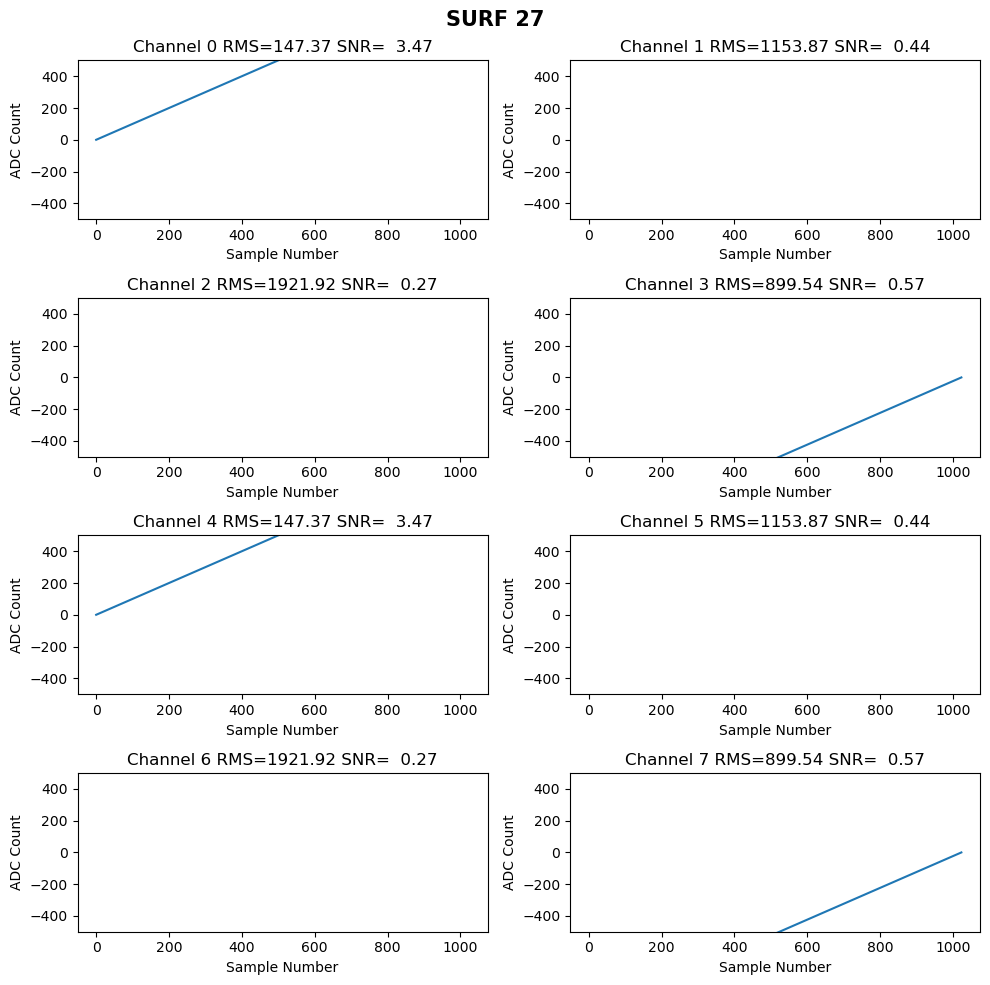

In [11]:
data = np.empty((0))
for i in range(len(theEvent)):
    ## First 8 bytes of each fragments is the header, strip that off (offset = 8) during byte reading and concatenation
    data = np.concatenate((data, np.frombuffer(theEvent[i], dtype = np.int16, offset = 8)))
print(len(data))
## First 128 bytes of data is more headers, remove it
data = data[128:]


## plot entire data stream for quick viewing
#plt.plot(data, linestyle = '-')
#plt.show()

## Reshape to be split into SURF#, Channel#
data = np.reshape(data, (28, 8, 1024))

## Plot all the different surfs and channels on seperate graphs
fn = []
for ii in [21,22,23,24,25,26,27]:
    fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize=(10,10))

    plt.suptitle('SURF ' + str(ii), fontsize = 15, fontweight = 'bold')
    for i in range(8):
        rms=np.sqrt(np.mean(np.square(data[ii,i,0:256])))
        pkpk=np.max(data[ii,i,:])-np.min(data[ii,i,:])
        snr=0.5*pkpk/rms            
        if (i%2==0):
            axs[i//2, 0].plot(data[ii, i])
            axs[i//2, 0].set_title('Channel ' + str(i) + f" RMS={rms:6.2f} SNR={snr:6.2f}")
            axs[i//2, 0].set_xlabel('Sample Number')
            axs[i//2, 0].set_ylabel('ADC Count')
            axs[i//2, 0].set_ylim(ymin=-500, ymax=500)

        else:
            axs[(i-1)//2, 1].plot(data[ii, i])
            axs[(i-1)//2, 1].set_title('Channel ' + str(i) + f" RMS={rms:6.2f} SNR={snr:6.2f}")
            axs[(i-1)//2, 1].set_xlabel('Sample Number')
            axs[(i-1)//2, 1].set_ylabel('ADC Count')
            axs[(i-1)//2, 1].set_ylim(ymin=-500, ymax=500)
        


    #fig.savefig('test.pdf')
    plt.tight_layout()
    #plt.show()
    filename = './SURF_' + str(ii) + 'data.pdf'
    fig.savefig(filename)
    fn.append(filename)


## Merge all the graphs into a single pdf
merger = PdfWriter()

for pdf in fn:
    merger.append(pdf)

merger.write("test.pdf")
merger.close()
#plt.show()

In [ ]:
#delay and sum with beam 5
#NEED TO LOWPASS FILTER FIRST
#ALSO MATCHED FILTER
#DO THESE BEFORE SCALING
delays=[0,13,13,13,1,13,13,13] #BEAM 5
lpk=[-23.,0.,105.,0.,-263.,0.,526.,0.,-949.,0.,1672.,0.,-3216.,0.,10342.,16384.,10342.,0.,-3216.,0.,1672.,0.,-949.,0.,526.,0.,-263.,0.,105.,0.,-23.]
mfk=[ 1,1,-1,-2,1,4,1,-4,-4,0,4,2,0,-2,-2,-1,0,1,2,1,0,-1,-1,-1,0,1,1,1,1,0, -1,-1,-1,0,0,1,1]
for ii in [26,25]:
    delsum=np.zeros(512)
    data = np.apply_along_axis(lambda m: np.convolve(m,lpk, mode='valid'), axis=-1, arr=data)
    print(data.shape)
    data = np.apply_along_axis(lambda m: np.convolve(m,mfk[::-1], mode='valid'), axis=-1, arr=data)
    print(data.shape)
    for i in range(8):
        rms=np.sqrt(np.mean(np.square(data[ii,i,0:200])))
        snippet=data[ii,i,(256-delays[i]):(768-delays[i])]
        snippet=4*snippet/rms
        delsum=delsum+snippet
    delrms=np.sqrt(np.mean(np.square(delsum)))
    #REMEMBER TO SATURATE THE SNIPPETS AT +/- 15.5 AND DO THE WHOLE RECORD (OR MORE THAN MIDDLE HALF)
    #pkpk=np.max(data[ii,i,:])-np.min(data[ii,i,:])
    #snr=0.5*pkpk/rms 
    boxcar=np.ones(16)
    trig=np.convolve(boxcar,np.square(delsum), mode="valid")
    print(len(trig))
    maxtrig=np.max(trig)
    mintrig=np.min(trig)
    print(f"Surf {ii:2d}, Max: {np.max(delsum)}, Min: {np.min(delsum)}, RMS: {delrms:5.2f}, Trig: {maxtrig} {mintrig}") 
    

In [ ]:
print(delsum)

In [ ]:
plt.plot(delsum)

In [ ]:
print(trig)

In [ ]:
plt.plot(trig)